<a href="https://colab.research.google.com/github/TobiBu/graddays/blob/main/day_3/notebooks/neural_ODE_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural ODE tutorial

This tutorial notebook is originally taken from Patrick Kidger and will show you how to use neural ODEs as a modelling framework.

In [ ]:
!pip install diffrax equinox jax jaxlib matplotlib optax

In [ ]:
# Don't display any output that isn't a graph
import sys
from io import StringIO
sys.stdout = StringIO()
sys.stderr = StringIO()

# Imports
import equinox as eqx
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5
import jax
import jax.flatten_util as jfu
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax

# Increase graph resolution
plt.rcParams["figure.figsize"] = [6*2.2, 4*2.2]
plt.rcParams["figure.dpi"] = 300

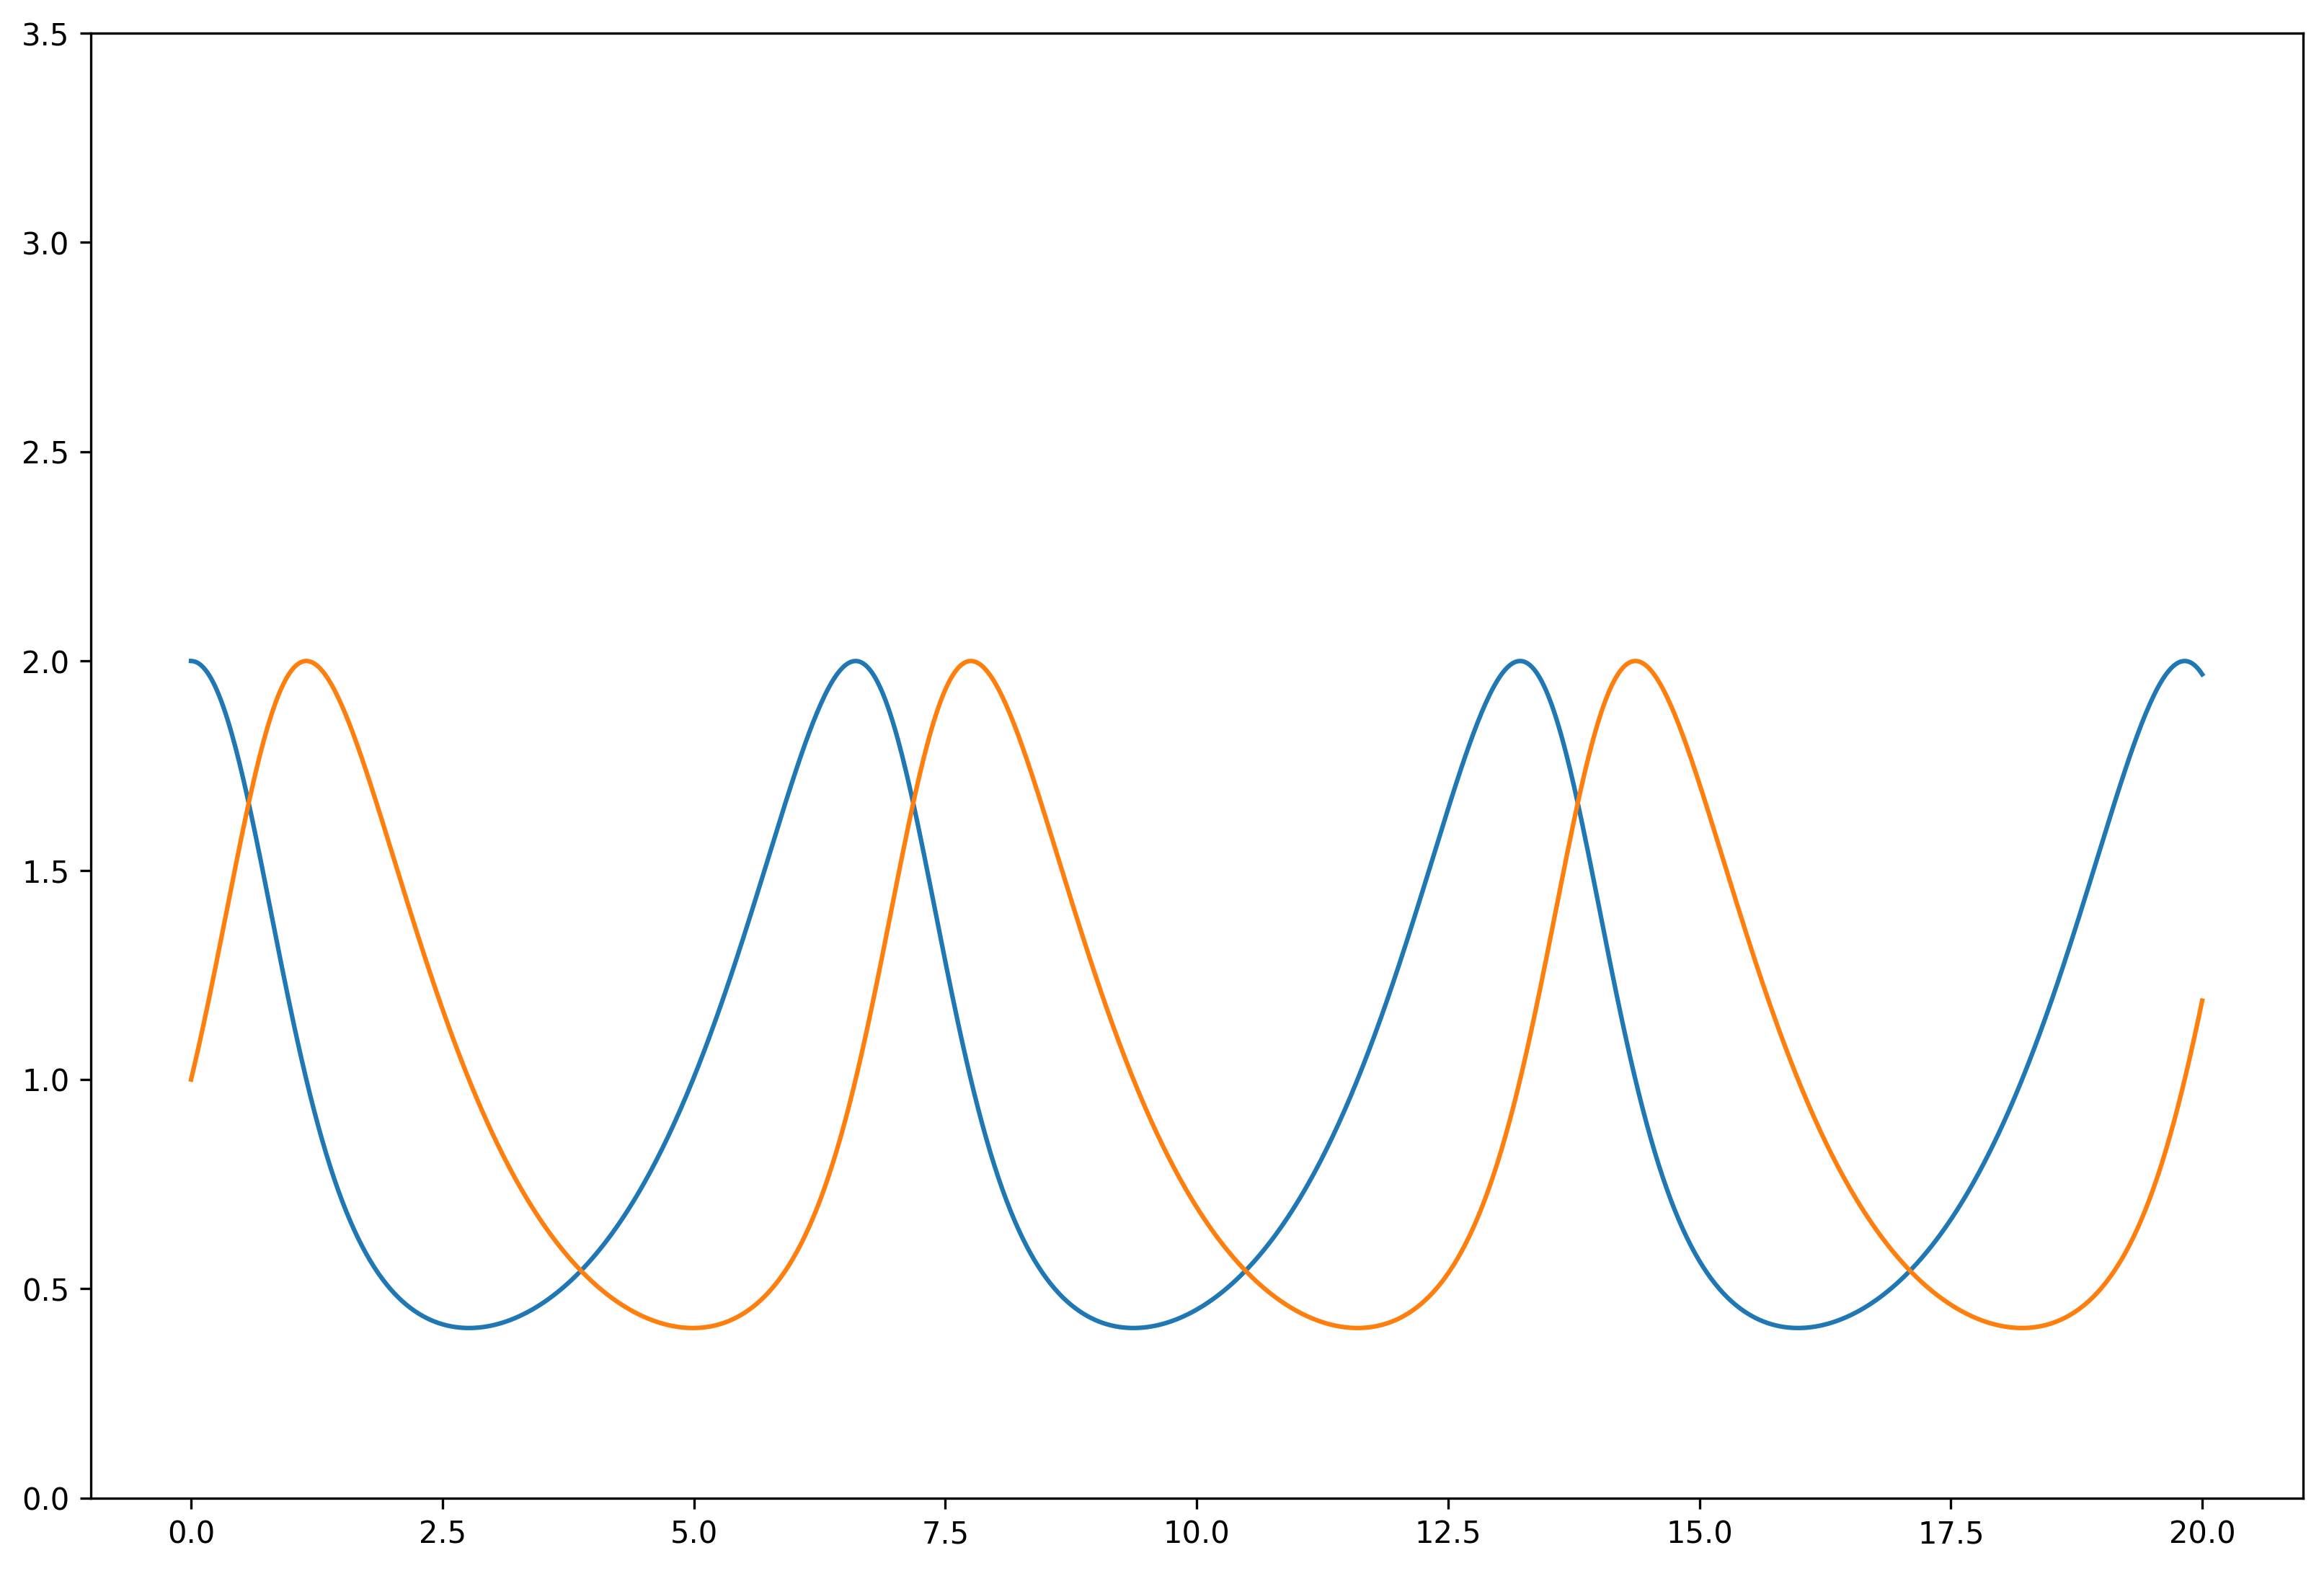

In [ ]:
# Unparameterised Lotka-Volterra
def f(t, y, _):
  b, c = y
  db_dt = b - b * c
  dc_dt = -c + b * c
  return db_dt, dc_dt

b0 = 2; c0 = 1  # bunnies and cats
ts = jnp.linspace(0, 20, 1000)
sol = diffeqsolve(ODETerm(f), Tsit5(), t0=0, t1=20, dt0=0.01,
                  y0=(b0, c0), saveat=SaveAt(ts=ts))
plt.ylim(0, 3.5); plt.plot(ts, sol.ys[0]); plt.plot(ts, sol.ys[1]);

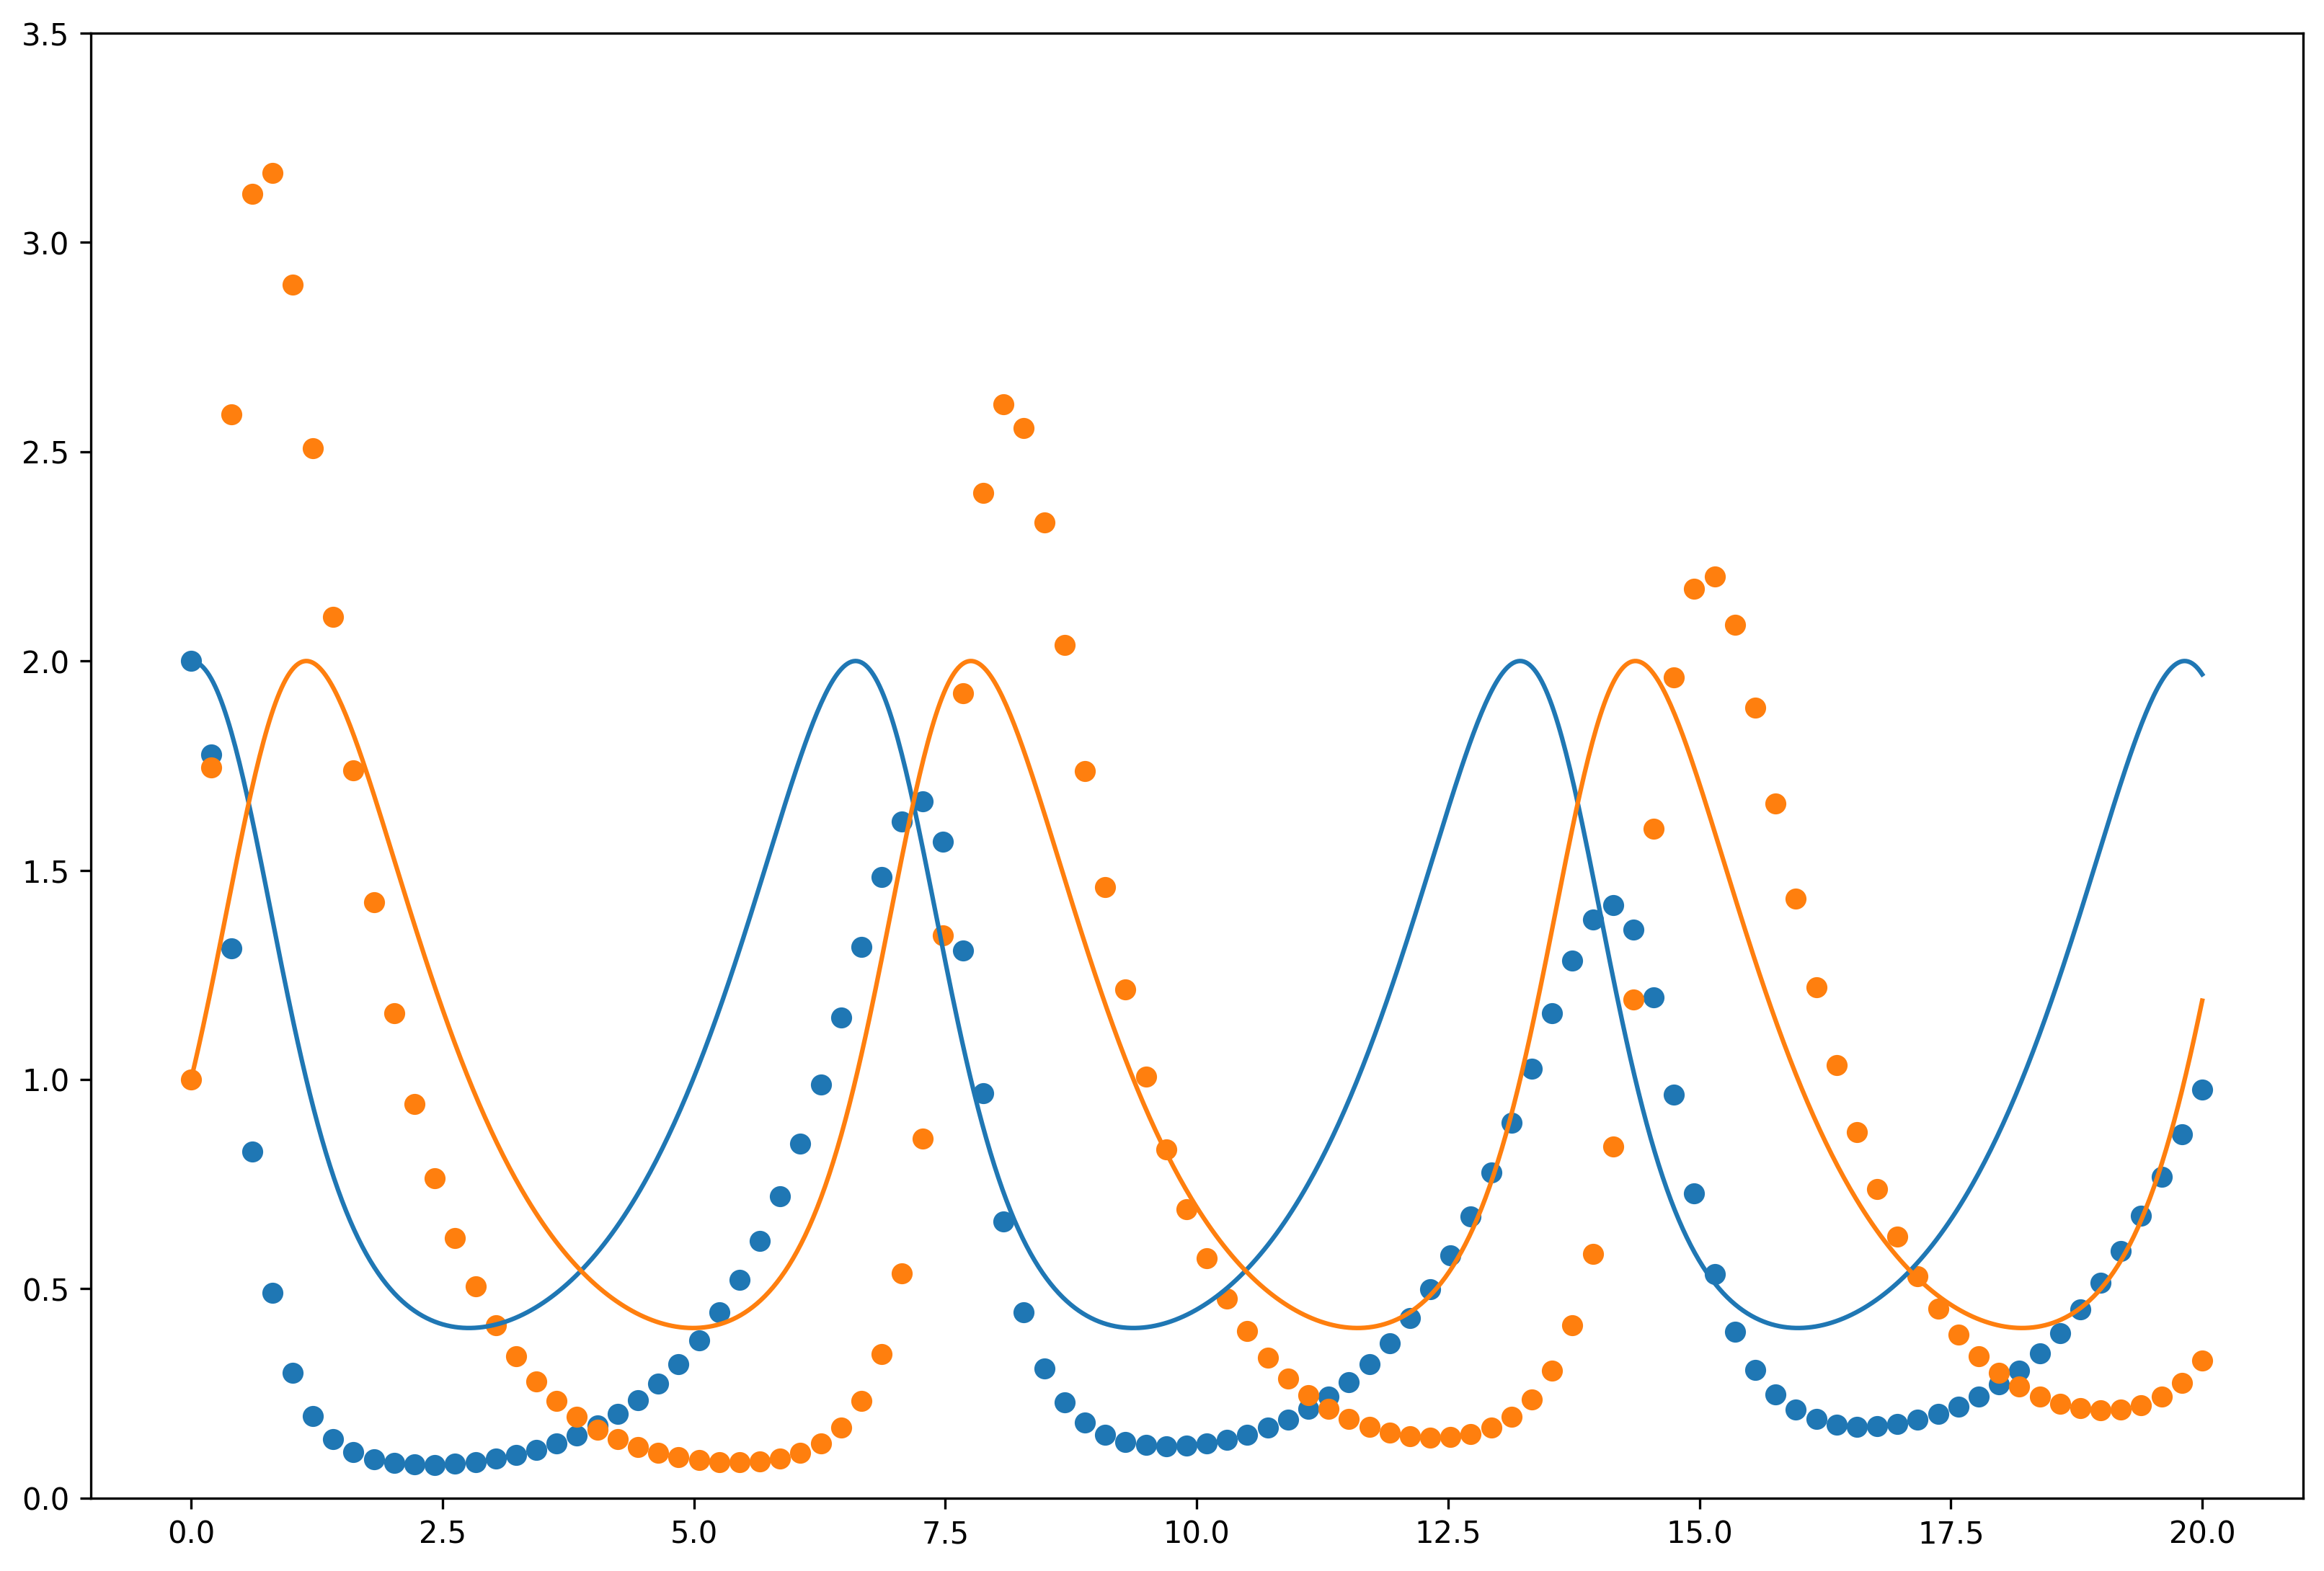

In [ ]:
# Unfortunately, our data may be generated from a different process.
def f(t, y, _):
  b, c = y
  db_dt = 0.9 * b - 1.1 * b * c
  dc_dt = -1.2 * c + 2.1 * b * c**0.95
  return db_dt, dc_dt

b0 = 2; c0 = 1  # bunnies and cats
data_ts = jnp.linspace(0, 20, 100)
data_sol = diffeqsolve(ODETerm(f), Tsit5(), t0=0, t1=20, dt0=0.01,
                       y0=(b0, c0), saveat=SaveAt(ts=data_ts))
plt.ylim(0, 3.5); plt.plot(ts, sol.ys[0]); plt.plot(ts, sol.ys[1]);
plt.scatter(data_ts, data_sol.ys[0]); plt.scatter(data_ts, data_sol.ys[1]);

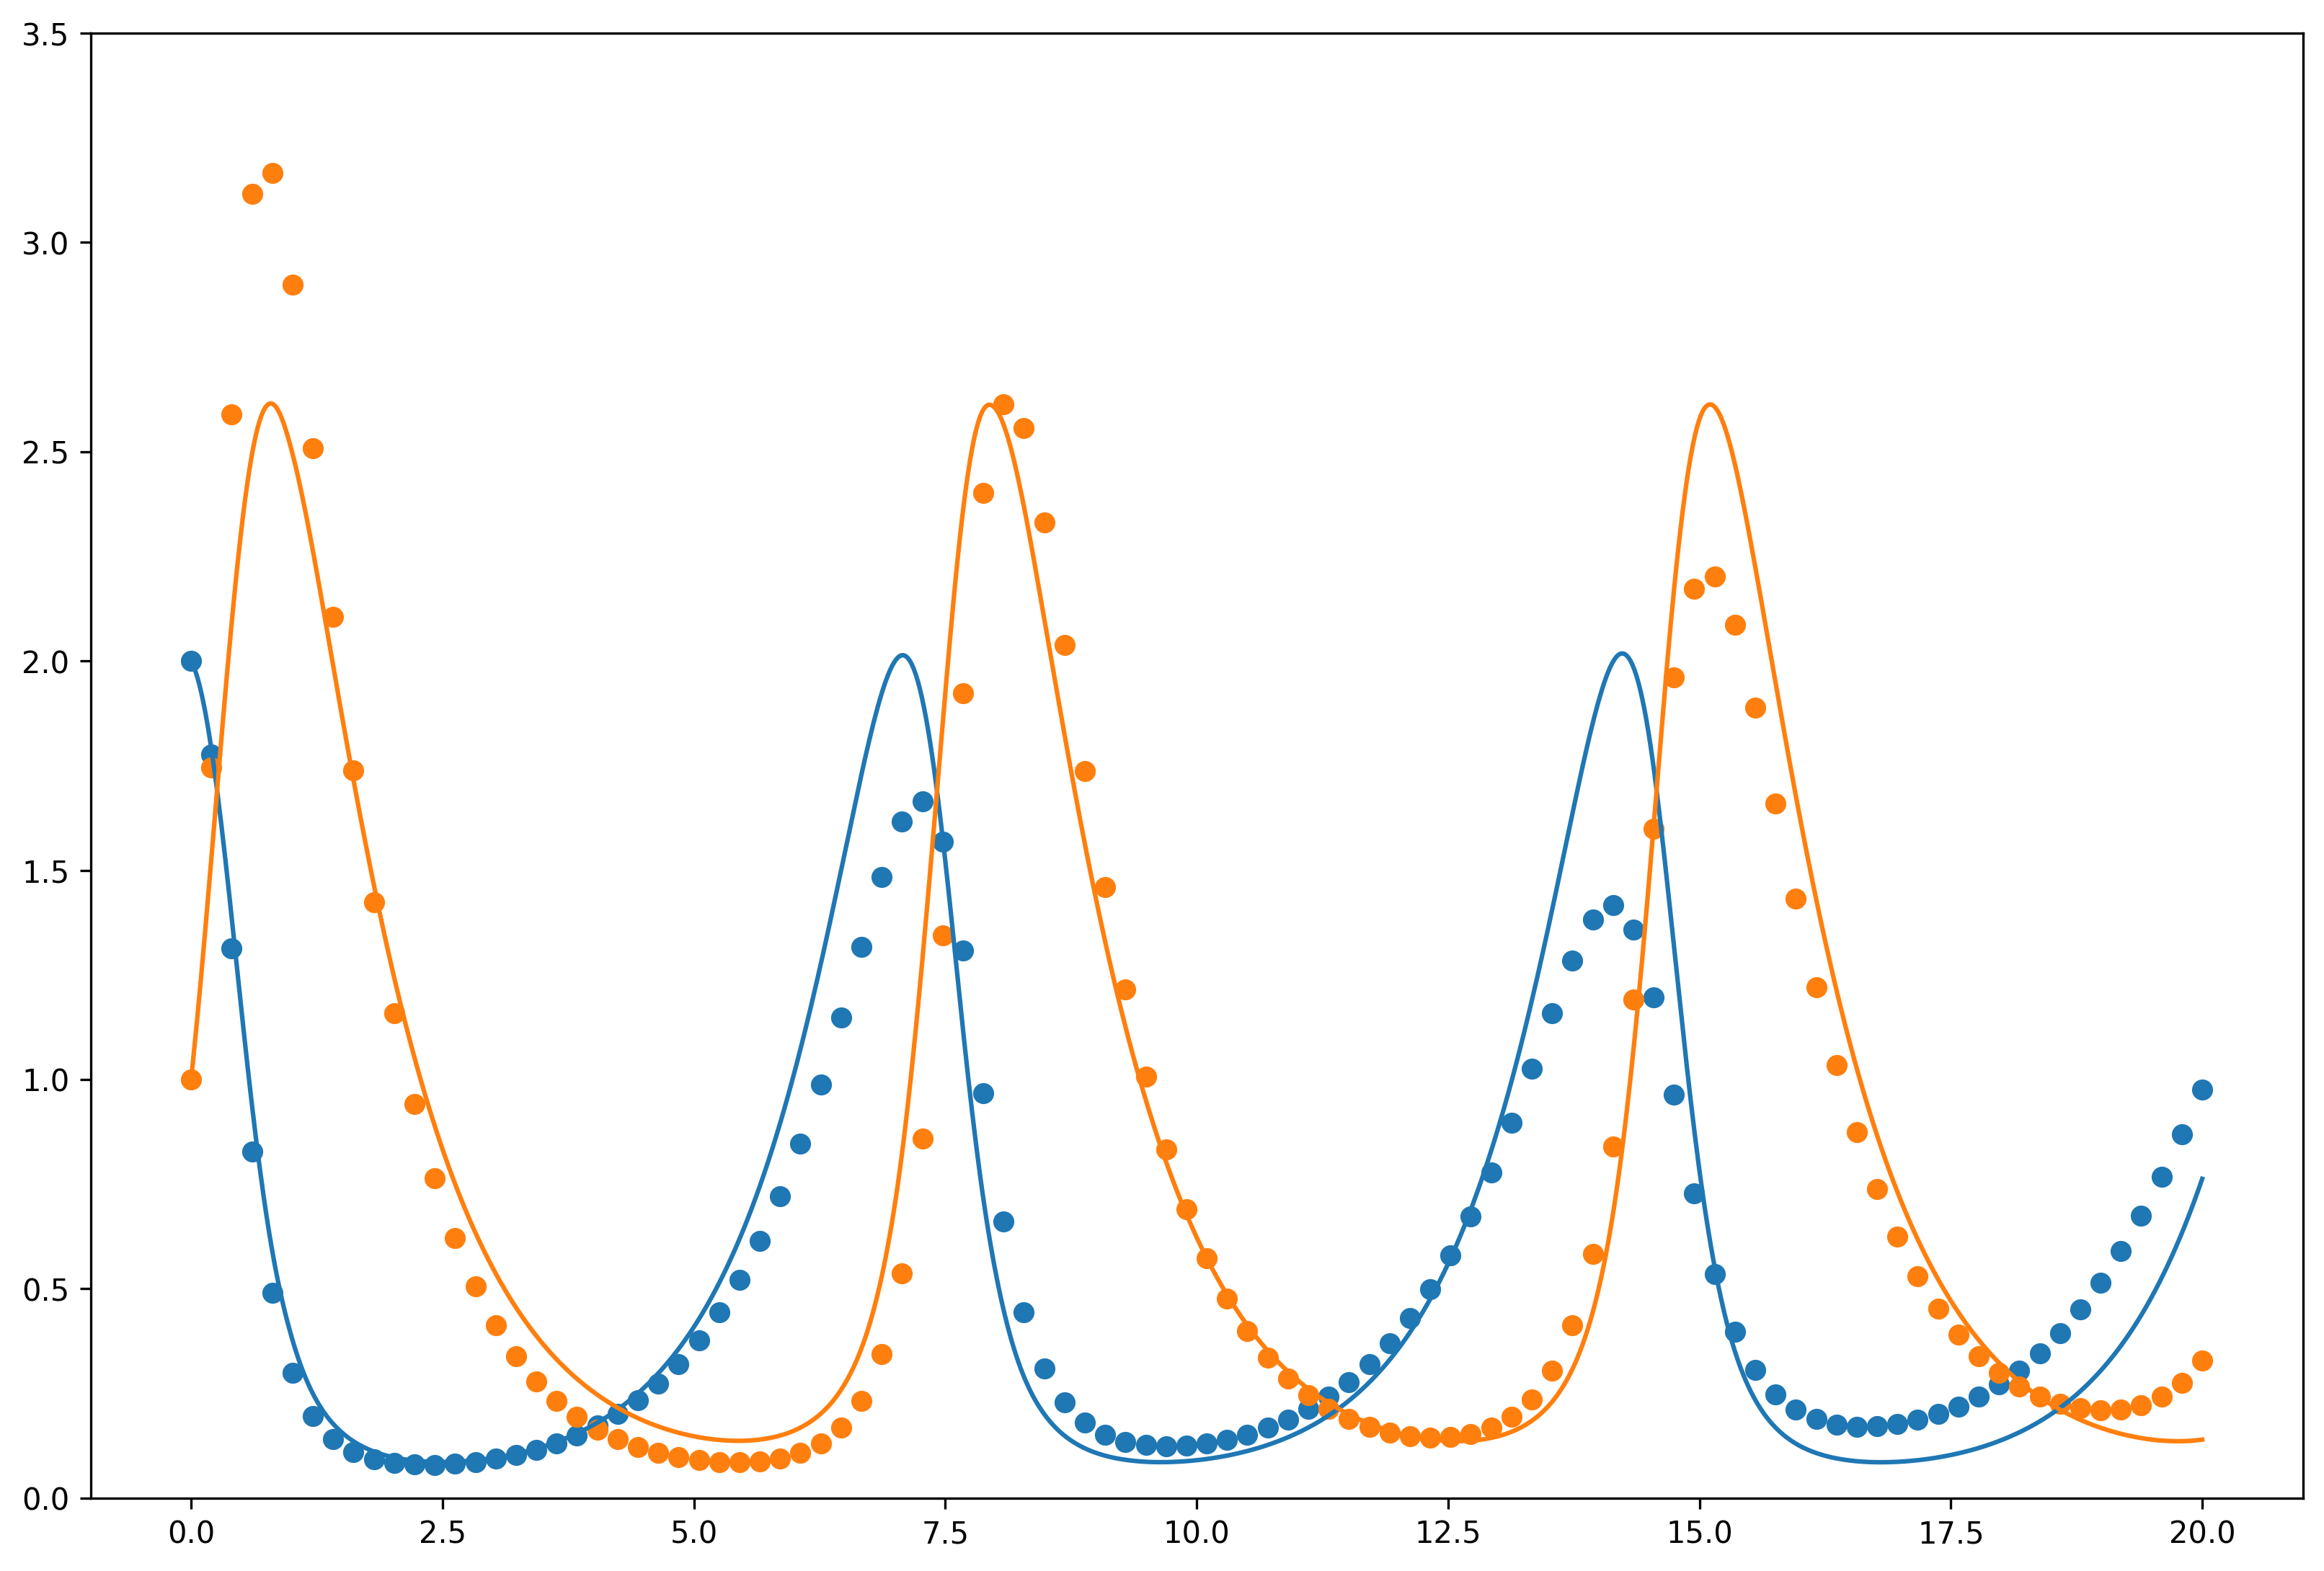

In [ ]:
# Parameterised Lotka-Volterra

def fwd(coeffs, num_ts):
  def f(t, y, _coeffs):
    α, β, γ, δ = _coeffs
    b, c = y
    db_dt = α * b - β * b * c
    dc_dt = -γ * c + δ * b * c
    return db_dt, dc_dt

  b0 = 2; c0 = 1
  model_ts = jnp.linspace(0, 20, num_ts)
  # Note: larger dt0 so that it runs faster; this is about as large as it can go
  model_sol = diffeqsolve(ODETerm(f), Tsit5(), t0=0, t1=20, dt0=0.5,
                        y0=(b0, c0), args=coeffs, saveat=SaveAt(ts=model_ts))
  return model_sol

def loss(coeffs):
  model_sol = fwd(coeffs, 100)
  model_b, model_c = model_sol.ys
  data_b, data_c = data_sol.ys
  return jnp.sum((model_b - data_b)**2) + jnp.sum((model_c - data_c)**2)

@jax.jit
def train_step(coeffs, opt_state):
  grads = jax.grad(loss)(coeffs)
  updates, opt_state = opt.update(grads, opt_state)
  coeffs = optax.apply_updates(coeffs, updates)
  return coeffs, opt_state

coeffs = (1., 1., 1., 1.)
opt = optax.adam(3e-2)
opt_state = opt.init(coeffs)

for _ in range(80):
  coeffs, opt_state = train_step(coeffs, opt_state)
model_sol = fwd(coeffs, 1000)
plt.ylim(0, 3.5);
plt.plot(ts, model_sol.ys[0]); plt.plot(ts, model_sol.ys[1]);
plt.scatter(data_ts, data_sol.ys[0]); plt.scatter(data_ts, data_sol.ys[1]);

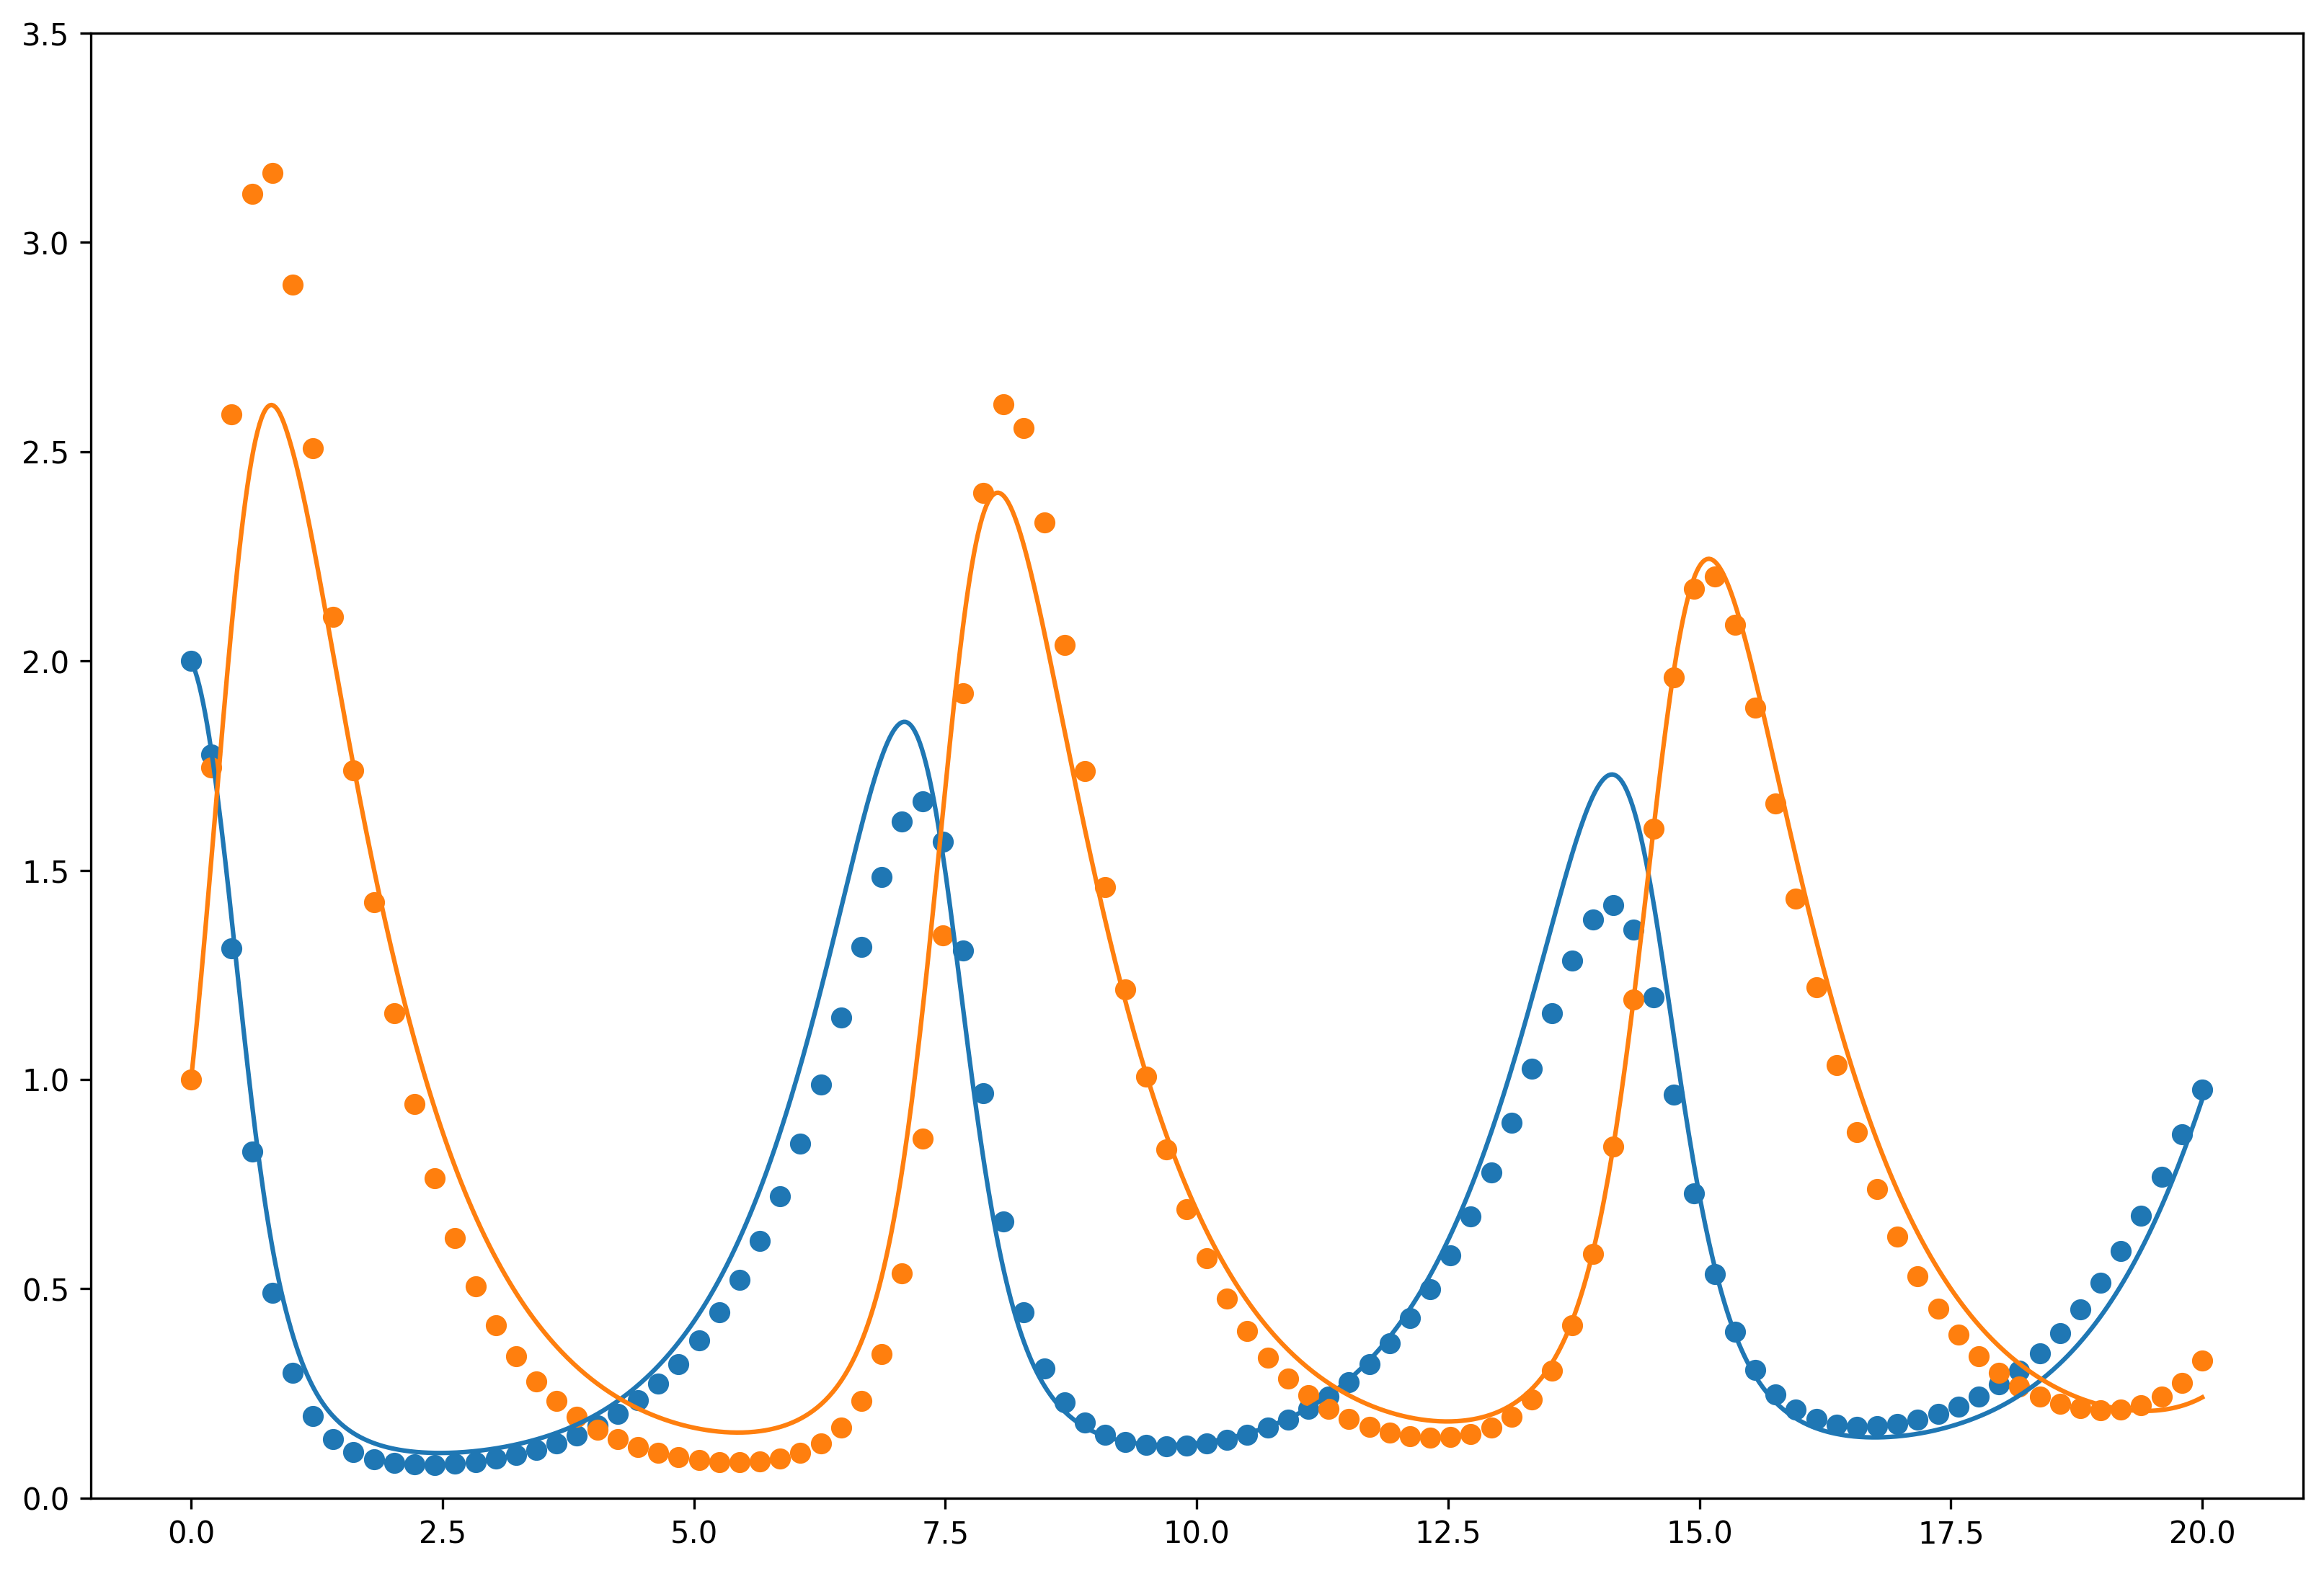

In [ ]:
# Neurally parameterised Lotka-Volterra: version 1

def fwd(mlp, coeffs, num_ts):
  def f(t, y, _mlp):
    α, β, γ, δ = coeffs
    b, c = y
    db_dt = α * b - β * b * c + 0.1 * _mlp(jfu.ravel_pytree((b, c))[0])[0]
    dc_dt = -γ * c + δ * b * c
    return db_dt, dc_dt

  b0 = 2; c0 = 1
  model_ts = jnp.linspace(0, 20, num_ts)
  model_sol = diffeqsolve(ODETerm(f), Tsit5(), t0=0, t1=20, dt0=0.5,
                        y0=(b0, c0), args=mlp, saveat=SaveAt(ts=model_ts))
  return model_sol

def loss(mlp, coeffs):
  model_sol = fwd(mlp, coeffs, 100)
  model_b, model_c = model_sol.ys
  data_b, data_c = data_sol.ys
  return jnp.sum((model_b - data_b)**2) + jnp.sum((model_c - data_c)**2)

@eqx.filter_jit
def train_step(mlp, coeffs, opt_state):
  grads = eqx.filter_grad(loss)(mlp, coeffs)
  updates, opt_state = opt.update(grads, opt_state)
  mlp = eqx.apply_updates(mlp, updates)
  return mlp, opt_state

mlp = eqx.nn.MLP(2, 1, 4, 1, key=jr.PRNGKey(0))
opt = optax.adam(3e-3)
opt_state = opt.init(eqx.filter(mlp, eqx.is_array))

for _ in range(300):
  mlp, opt_state = train_step(mlp, coeffs, opt_state)
model_sol = fwd(mlp, coeffs, 1000)
plt.ylim(0, 3.5);
plt.plot(ts, model_sol.ys[0]); plt.plot(ts, model_sol.ys[1]);
plt.scatter(data_ts, data_sol.ys[0]); plt.scatter(data_ts, data_sol.ys[1]);

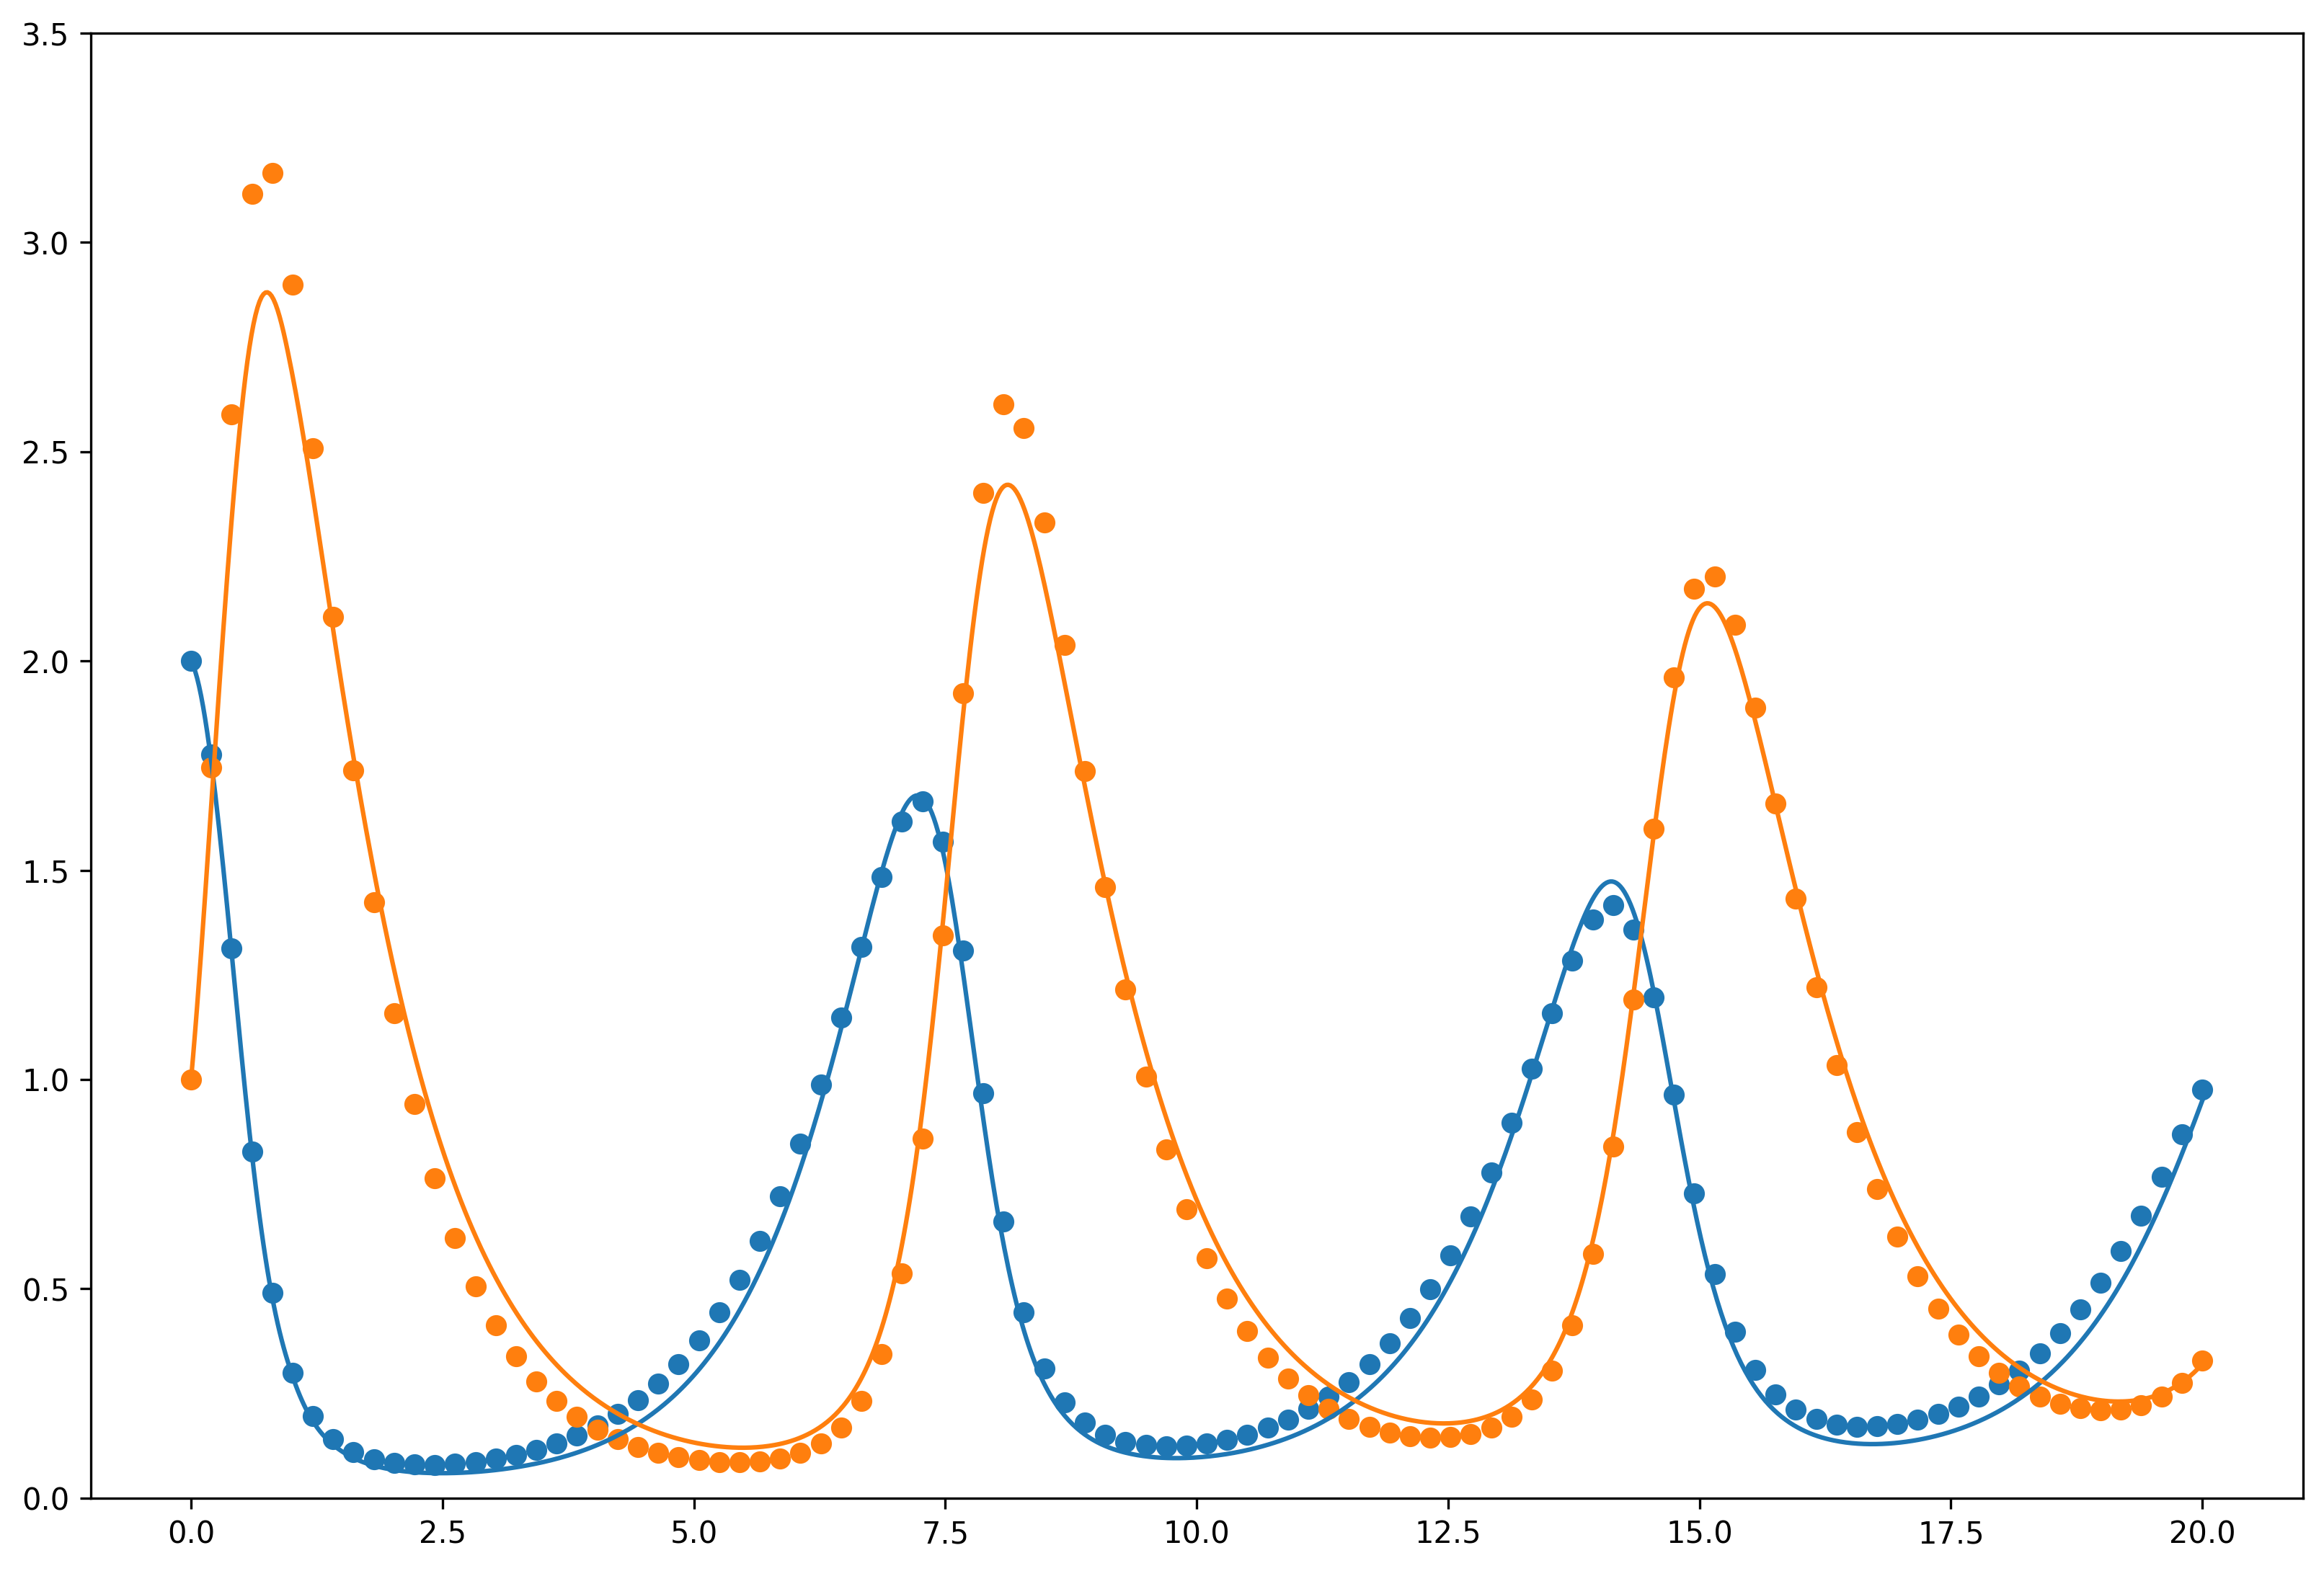

In [ ]:
# Neurally parameterised Lotka-Volterra: version 2

def fwd(mlp, coeffs, num_ts):
  def f(t, y, _mlp):
    α, β, γ, δ = coeffs
    b, c = y
    db_dt = α * b - β * b * c
    dc_dt = -γ * c + δ * b * (c + 0.1 * _mlp(jfu.ravel_pytree((b, c))[0])[0])
    return db_dt, dc_dt

  b0 = 2; c0 = 1
  model_ts = jnp.linspace(0, 20, num_ts)
  model_sol = diffeqsolve(ODETerm(f), Tsit5(), t0=0, t1=20, dt0=0.5,
                        y0=(b0, c0), args=mlp, saveat=SaveAt(ts=model_ts))
  return model_sol

def loss(mlp, coeffs):
  model_sol = fwd(mlp, coeffs, 100)
  model_b, model_c = model_sol.ys
  data_b, data_c = data_sol.ys
  return jnp.sum((model_b - data_b)**2) + jnp.sum((model_c - data_c)**2)

@eqx.filter_jit
def train_step(mlp, coeffs, opt_state):
  grads = eqx.filter_grad(loss)(mlp, coeffs)
  updates, opt_state = opt.update(grads, opt_state)
  mlp = eqx.apply_updates(mlp, updates)
  return mlp, opt_state

mlp = eqx.nn.MLP(2, 1, 4, 1, key=jr.PRNGKey(0))
opt = optax.adam(3e-3)
opt_state = opt.init(eqx.filter(mlp, eqx.is_array))

for _ in range(300):
  mlp, opt_state = train_step(mlp, coeffs, opt_state)
model_sol = fwd(mlp, coeffs, 1000)
plt.ylim(0, 3.5);
plt.plot(ts, model_sol.ys[0]); plt.plot(ts, model_sol.ys[1]);
plt.scatter(data_ts, data_sol.ys[0]); plt.scatter(data_ts, data_sol.ys[1]);